In [18]:
import sys, os
from pathlib import Path

ROOT = Path.cwd()
while ROOT.name and not (ROOT/"src").exists():
    ROOT = ROOT.parent
print("Project root:", ROOT)

# src'yi paket yap (bir kez yeter; varsa dokunmaz)
(Path(ROOT/"src"/"__init__.py")).touch()

# notebook sürecinde de src'yi görünür yap
sys.path.insert(0, str(ROOT))


Project root: c:\Users\merts\Desktop\ml_basics\credit-scoring


In [19]:
# Hangi modeli eğitelim? 'lr' | 'xgb' | 'lgb'
MODEL = "xgb"

# Eşik seçerken maliyetler (isteğe göre güncelle)
COST_FP = 1.0
COST_FN = 5.0

TARGET = "seriousdlqin2yrs"


In [20]:
MODEL = "xgb"

import sys
sys.argv = ["", "--model", MODEL]
from src.train import main
main()


c:\Users\merts\Desktop\ml_basics\credit-scoring\.venv\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


VAL -> ROC-AUC: 0.8750 | PR-AUC (AP): 0.3827
TEST -> ROC-AUC: 0.8691 | PR-AUC (AP): 0.4058
Saved model to C:\Users\merts\Desktop\ml_basics\credit-scoring\models\best_model.pkl
Saved feature names for app (models/feature_names.json).


In [21]:
import sys
from pathlib import Path

# Proje kökünü bul (src klasörüne göre)
ROOT = next(p for p in [Path.cwd(), *Path.cwd().parents] if (p/"src").exists())
sys.path.insert(0, str(ROOT))

from src.data_prep import load_raw, basic_clean, train_val_test_split
from src.utils import DATA_RAW, BEST_MODEL_PATH   # <-- BURADAN AL
from pathlib import Path

REPORTS_DIR = ROOT / "reports"
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

TARGET = "seriousdlqin2yrs"

df = basic_clean(load_raw(DATA_RAW))
Xtr, Xval, Xte, ytr, yval, yte = train_val_test_split(df, TARGET)

# Modeli doğru yerden yükle
print("Model path ->", BEST_MODEL_PATH.resolve())
assert BEST_MODEL_PATH.exists(), "Model dosyası bulunamadı!"

import joblib
pipe = joblib.load(BEST_MODEL_PATH)   # FE+Pre+Model pipeline

proba_te  = pipe.predict_proba(Xte)[:, 1]
proba_val = pipe.predict_proba(Xval)[:, 1]

print("Loaded model and created VAL/TEST probabilities.")


Model path -> C:\Users\merts\Desktop\ml_basics\credit-scoring\models\best_model.pkl
Loaded model and created VAL/TEST probabilities.


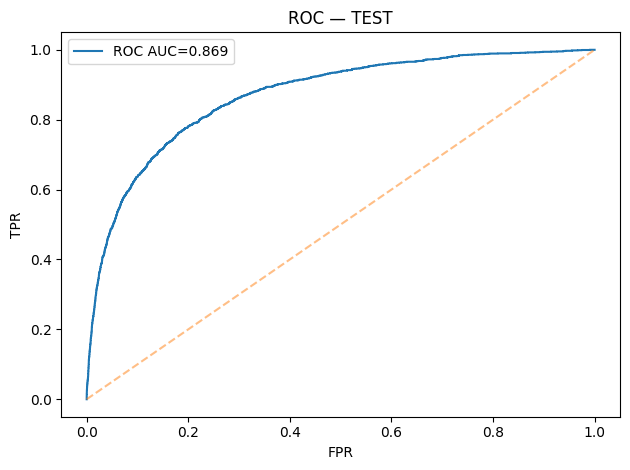

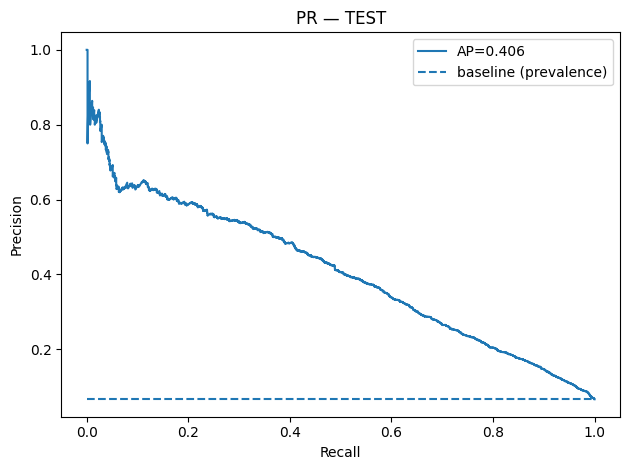

Saved: c:/Users/merts/Desktop/ml_basics/credit-scoring/reports/roc_test.png c:/Users/merts/Desktop/ml_basics/credit-scoring/reports/pr_test.png


In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc, average_precision_score

# ROC
fpr, tpr, _ = roc_curve(yte, proba_te)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC AUC={roc_auc:.3f}")
plt.plot([0,1],[0,1],"--", alpha=.5)
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC — TEST"); plt.legend()
plt.tight_layout(); plt.savefig(REPORTS_DIR/"roc_test.png", dpi=160); plt.show()

# PR
prec, rec, _ = precision_recall_curve(yte, proba_te)
ap = average_precision_score(yte, proba_te)

plt.figure()
plt.plot(rec, prec, label=f"AP={ap:.3f}")
plt.hlines(y=yte.mean(), xmin=0, xmax=1, linestyles="--", label="baseline (prevalence)")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR — TEST"); plt.legend()
plt.tight_layout(); plt.savefig(REPORTS_DIR/"pr_test.png", dpi=160); plt.show()

print("Saved:", (REPORTS_DIR/"roc_test.png").as_posix(), (REPORTS_DIR/"pr_test.png").as_posix())


In [23]:
import numpy as np

def topk_recall(y_true, proba, k):
    n = len(proba); take = max(1, int(np.ceil(k*n)))
    idx = np.argsort(-proba)[:take]
    pos = (y_true==1).sum()
    return (y_true.to_numpy()[idx]==1).sum()/max(pos,1)

def precision_at_k(y_true, proba, k):
    n = len(proba); take = max(1, int(np.ceil(k*n)))
    idx = np.argsort(-proba)[:take]
    return (y_true.to_numpy()[idx]==1).mean()

for K in (0.05, 0.10, 0.20):
    print(f"K={int(K*100)}%  TopK-Recall={topk_recall(yte, proba_te, K):.3f}  |  Precision@K={precision_at_k(yte, proba_te, K):.3f}")


K=5%  TopK-Recall=0.373  |  Precision@K=0.498
K=10%  TopK-Recall=0.560  |  Precision@K=0.374
K=20%  TopK-Recall=0.735  |  Precision@K=0.246


In [24]:
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, classification_report

COST_FP = 1.0
COST_FN = 5.0

best = {"t":None, "cost":1e18, "f1":-1, "rec":0, "prec":0}
for t in np.linspace(0.02, 0.98, 49):
    y_pred_v = (proba_val>=t).astype(int)
    tn, fp, fn, tp = confusion_matrix(yval, y_pred_v).ravel()
    cost = fp*COST_FP + fn*COST_FN
    f1 = f1_score(yval, y_pred_v, zero_division=0)
    rec = tp/max(tp+fn,1); prec = tp/max(tp+fp,1)
    if cost < best["cost"] or (np.isclose(cost, best["cost"]) and f1>best["f1"]):
        best = {"t":float(t), "cost":float(cost), "f1":float(f1), "rec":float(rec), "prec":float(prec)}

print("Best on VAL:", best)

# TEST'e uygula
t_star = best["t"]
y_pred_te = (proba_te >= t_star).astype(int)
print("Threshold* (from VAL):", t_star)
print("Confusion matrix (TEST):\n", confusion_matrix(yte, y_pred_te))
print(classification_report(yte, y_pred_te, digits=4))


Best on VAL: {'t': 0.7000000000000001, 'cost': 764.0, 'f1': 0.4482758620689655, 'rec': 0.6215139442231076, 'prec': 0.350561797752809}
Threshold* (from VAL): 0.7000000000000001
Confusion matrix (TEST):
 [[22542  1954]
 [  714  1040]]
              precision    recall  f1-score   support

           0     0.9693    0.9202    0.9441     24496
           1     0.3474    0.5929    0.4381      1754

    accuracy                         0.8984     26250
   macro avg     0.6583    0.7566    0.6911     26250
weighted avg     0.9277    0.8984    0.9103     26250



In [25]:
import json
report = {
    "roc_auc_test": float(roc_auc),
    "ap_test": float(ap),
    "prevalence_test": float(yte.mean()),
    "threshold_val_star": float(t_star),
    "val_cost_weights": {"FP": COST_FP, "FN": COST_FN},
    "best_val": best,
}
with open(REPORTS_DIR/"metrics.json","w") as f:
    json.dump(report, f, indent=2)
print("Saved:", (REPORTS_DIR/"metrics.json").as_posix())


Saved: c:/Users/merts/Desktop/ml_basics/credit-scoring/reports/metrics.json


In [27]:
from pathlib import Path
import json, numpy as np

# Proje kökünü bul (notebook nerede olursa olsun)
ROOT = next(p for p in [Path.cwd(), *Path.cwd().parents] if (p / "src").exists())

# Top-K %10 politikası (eşik VAL olasılıklarının 90. yüzdeliğinden)
POLICY = {
    "type": "topk",
    "K": 0.10,
    "threshold": float(np.quantile(proba_val, 0.90))
}

POLICY_PATH = ROOT / "models" / "policy.json"
POLICY_PATH.parent.mkdir(parents=True, exist_ok=True)
POLICY_PATH.write_text(json.dumps(POLICY, indent=2), encoding="utf-8")
print("Saved:", POLICY_PATH)
POLICY


Saved: c:\Users\merts\Desktop\ml_basics\credit-scoring\models\policy.json


{'type': 'topk', 'K': 0.1, 'threshold': 0.7487037301063536}

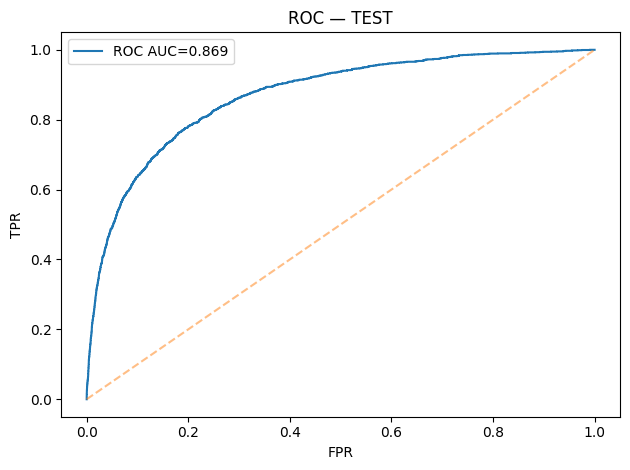

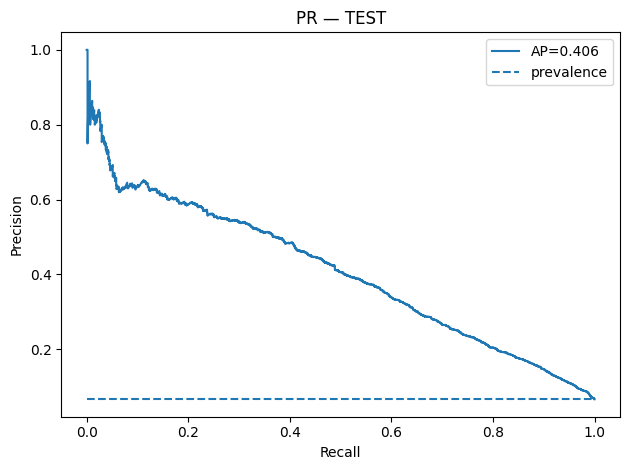

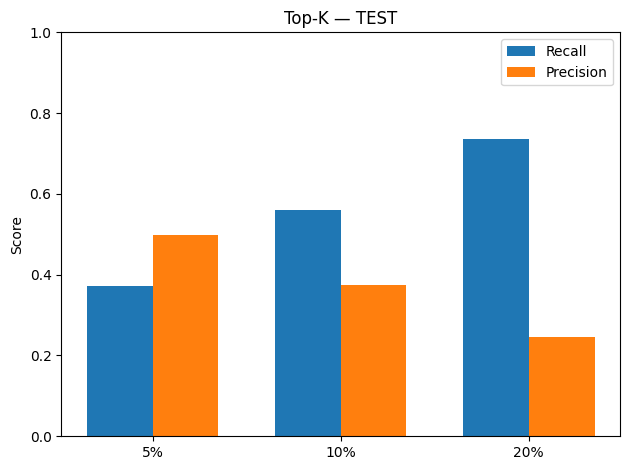

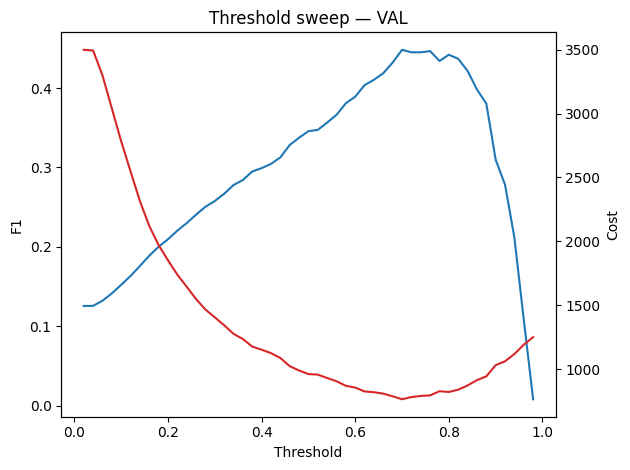

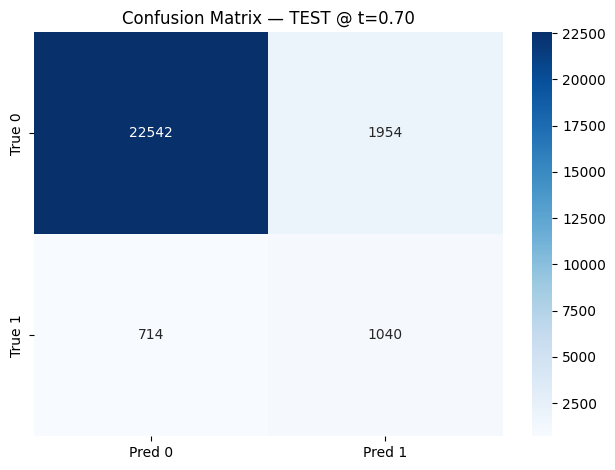

In [28]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve, average_precision_score,
    confusion_matrix
)

REPORTS_DIR = Path("reports"); REPORTS_DIR.mkdir(exist_ok=True, parents=True)

# 1) ROC (TEST)
fpr, tpr, _ = roc_curve(yte, proba_te)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC AUC={roc_auc:.3f}")
plt.plot([0,1],[0,1],"--",alpha=.5)
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.title("ROC — TEST")
plt.tight_layout(); plt.savefig(REPORTS_DIR/"roc_test.png", dpi=180); plt.show()

# 2) PR (TEST)
prec, rec, _ = precision_recall_curve(yte, proba_te)
ap = average_precision_score(yte, proba_te)
plt.figure()
plt.plot(rec, prec, label=f"AP={ap:.3f}")
plt.hlines(y=yte.mean(), xmin=0, xmax=1, linestyles="--", label="prevalence")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.legend(); plt.title("PR — TEST")
plt.tight_layout(); plt.savefig(REPORTS_DIR/"pr_test.png", dpi=180); plt.show()

# 3) Top-K bar (TEST)
Ks = [0.05, 0.10, 0.20]
def topk_recall(y_true, proba, k):
    n=len(proba); take=max(1,int(np.ceil(k*n)))
    idx=np.argsort(-proba)[:take]; pos=(y_true==1).sum()
    return (y_true.to_numpy()[idx]==1).sum()/max(pos,1)
def precision_at_k(y_true, proba, k):
    n=len(proba); take=max(1,int(np.ceil(k*n)))
    idx=np.argsort(-proba)[:take]; return (y_true.to_numpy()[idx]==1).mean()

topk_rec = [topk_recall(yte, proba_te, k) for k in Ks]
topk_pre = [precision_at_k(yte, proba_te, k) for k in Ks]

plt.figure()
x = np.arange(len(Ks)); w=0.35
plt.bar(x-w/2, topk_rec, width=w, label="Recall")
plt.bar(x+w/2, topk_pre, width=w, label="Precision")
plt.xticks(x, [f"{int(k*100)}%" for k in Ks])
plt.ylim(0,1); plt.ylabel("Score"); plt.title("Top-K — TEST")
plt.legend(); plt.tight_layout(); plt.savefig(REPORTS_DIR/"topk_test.png", dpi=180); plt.show()

# 4) Threshold sweep özet grafikleri (VAL)
ts = np.linspace(0.02, 0.98, 49)
from sklearn.metrics import f1_score
COST_FP, COST_FN = 1.0, 5.0
f1s=[]; costs=[]
for t in ts:
    y_pred=(proba_val>=t).astype(int)
    tn,fp,fn,tp = confusion_matrix(yval, y_pred).ravel()
    costs.append(fp*COST_FP + fn*COST_FN)
    f1s.append(f1_score(yval, y_pred, zero_division=0))

fig, ax = plt.subplots()
ax.plot(ts, f1s, label="F1 (VAL)")
ax2 = ax.twinx()
ax2.plot(ts, costs, color="tab:red", label="Cost (VAL)")
ax.set_xlabel("Threshold"); ax.set_ylabel("F1"); ax2.set_ylabel("Cost")
ax.set_title("Threshold sweep — VAL")
fig.tight_layout(); fig.savefig(REPORTS_DIR/"threshold_sweep_val.png", dpi=180); plt.show()

# 5) Confusion matrix (TEST, seçilen eşik t_star)
cm = confusion_matrix(yte, (proba_te>=t_star).astype(int))
plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred 0","Pred 1"], yticklabels=["True 0","True 1"])
plt.title(f"Confusion Matrix — TEST @ t={t_star:.2f}")
plt.tight_layout(); plt.savefig(REPORTS_DIR/"cm_test.png", dpi=180); plt.show()
